# Bayesian Cosmological Parameter Estimation with Gravitational-Wave Standard Sirens

This notebook demonstrates **Bayesian inference in a high-dimensional cosmological model**
using **synthetic gravitational-wave (GW) standard siren data**.

We fit the parameters:
- $H_0$ (Hubble constant)
- $\Omega_m$ (matter density)
- $\Omega_\Lambda$ (dark energy density)
- $\Omega_r$ (radiation density)
- $w_0, w_a$ (dark energy equation of state: CPL parameterization)
- $T_{\rm CMB}$ (CMB temperature)

This example illustrates why **Bayesian methods are essential** for modern, multi-parameter cosmology.

## 1. Cosmological Model

We use a generalized Friedmann equation:

$$H(z)^2 = H_0^2 \left[ \Omega_m(1+z)^3 + \Omega_r(1+z)^4 + \Omega_\Lambda f_{\rm DE}(z) \right]$$

with CPL dark energy:

$$w(z) = w_0 + w_a \frac{z}{1+z}$$

$$f_{\rm DE}(z) = (1+z)^{3(1+w_0+w_a)} \exp\left(-3w_a \frac{z}{1+z}\right)$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm


c = 3e5  # km/s

def E(z, H0, Om, Ode, Or, w0, wa):
    fde = (1+z)**(3*(1+w0+wa)) * np.exp(-3*wa*z/(1+z))
    return np.sqrt(Om*(1+z)**3 + Or*(1+z)**4 + Ode*fde)

def luminosity_distance(z, params):
    H0, Om, Ode, Or, w0, wa, Tcmb = params
    zgrid = np.linspace(0, z, 300)
    integrand = c / (H0 * E(zgrid, H0, Om, Ode, Or, w0, wa))
    return (1+z) * np.trapz(integrand, zgrid)

## 2. Synthetic Gravitational-Wave Standard Siren Data

We generate mock GW events with:
- Measured luminosity distance
- Identified host galaxy redshift

Distance uncertainties are large, reflecting realistic GW observations.

<KeysViewHDF5 ['Eiso', 'Epeak', 'dL', 'deldL', 'det_KN', 'det_jet', 'iota', 'm1', 'm2', 'z']>


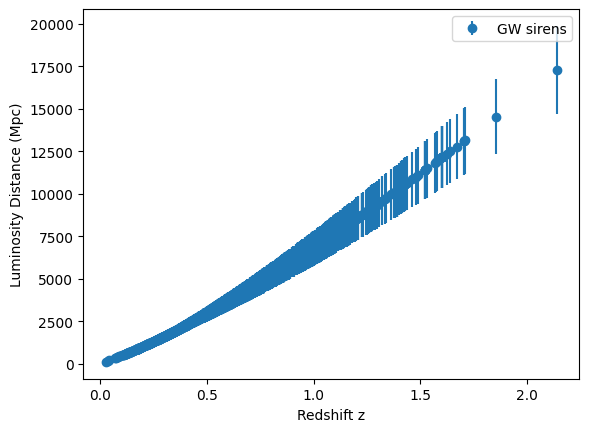

In [2]:
# read GW data
import h5py
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import LambdaCDM
from scipy.optimize import curve_fit

with h5py.File('nsns_population_joan.hdf5', 'r') as table:
    print(table.keys())
    complete_z = table['z'][()]
    complete_dL_obs = table['dL'][()]
    complete_dL_err = table['deldL'][()]
    complete_sigma_dL = 0.15 * complete_dL_obs

data = [complete_z, complete_dL_obs, complete_sigma_dL]

def reduce_sample_size(data, size):
    return [lst[:size] for lst in data]

z, dL_obs, sigma_dL = reduce_sample_size(data, 2000)

plt.errorbar(z, dL_obs, yerr=sigma_dL, fmt='o', label='GW sirens')
plt.xlabel('Redshift z')
plt.ylabel('Luminosity Distance (Mpc)')
plt.legend()
plt.show()

## 3. Likelihood Function

Assuming Gaussian distance errors:

$$\ln \mathcal{L} = -\frac{1}{2}\sum \frac{(d_L^{\rm obs} - d_L^{\rm model})^2}{\sigma_{d_L}^2}$$

In [3]:
def log_likelihood(params):
    H0, Om, Ode, Or, w0, wa, Tcmb = params
    if Om < 0 or Ode < 0 or Or < 0:
        return -np.inf
    model = np.array([luminosity_distance(zi, params) for zi in z])
    return -0.5 * np.sum((dL_obs - model)**2 / sigma_dL**2)

## 4. Priors

We impose broad, physically motivated priors to stabilize inference.

In [4]:
def log_prior(params):
    H0, Om, Ode, Or, w0, wa, Tcmb = params
    if not (50 < H0 < 90): return -np.inf
    if not (0 < Om < 1): return -np.inf
    if not (0 < Ode < 1): return -np.inf
    if not (0 < Or < 1e-3): return -np.inf
    if not (-2 < w0 < 0): return -np.inf
    if not (-2 < wa < 2): return -np.inf
    if not (2 < Tcmb < 3): return -np.inf
    return 0.0

def log_posterior(params):
    lp = log_prior(params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(params)

## 5. Simple MCMC Sampler (Metropolis–Hastings)

Grid methods fail in 7D parameter space.
We use a basic MCMC sampler to explore the posterior.

In [5]:
nsteps = 6000
step_scale = np.array([1, 0.02, 0.02, 1e-5, 0.05, 0.05, 0.01])
params_guess = [70, 0.3, 0.7, 9e-5, -1.0, 0.0, 2.725]
burn = 1000

def run_mcmc(nsteps, step_scale, params_guess, burn):
    chain = np.zeros((nsteps, 7))
    chain[0] = params_guess + np.random.normal(0, step_scale)

    logp = log_posterior(chain[0])

    for i in tqdm(range(1, nsteps)):
        proposal = chain[i-1] + np.random.normal(0, step_scale)
        logp_prop = log_posterior(proposal)
        if np.log(np.random.rand()) < logp_prop - logp:
            chain[i] = proposal
            logp = logp_prop
        else:
            chain[i] = chain[i-1]

    samples = chain[burn:]
    return samples

In [ ]:
samples = run_mcmc(nsteps, step_scale, params_guess, burn)

## 6. Posterior Constraints

We extract marginal constraints from the MCMC chain.

In [6]:
def read_samples(samples, nsteps, burn, dL_obs):
    labels = ['H0','Om','Ode','Or','w0','wa','Tcmb']
    
    with open('posteriors.txt', 'a') as f:
        f.write('\n')
        f.write(f'Steps: {nsteps} (burn: {burn}), Data length: {len(dL_obs)}\n')
    
    for i, lab in enumerate(labels):
        
        mean = np.mean(samples[:, i])
        std = np.std(samples[:, i])
        print(f'{lab}: {mean:.3f} ± {std:.3f}')
    
        with open('posteriors.txt', 'a') as f:
            f.write(f'{lab}: {mean:.3f} ± {std:.3f}\n')

read_samples(samples, nsteps, burn, dL_obs)

NameError: name 'samples' is not defined

## 7. Interpretation

This example shows:
- Strong degeneracies between cosmological parameters
- The necessity of priors in high-dimensional inference
- Why χ² minimization is insufficient

**Bayesian inference allows us to extract meaning, not just best fits.**

In [ ]:
import matplotlib.pyplot as plt

labels = ['H0','Om','Ode','Or','w0','wa','Tcmb']
ndim = samples.shape[1]

fig, axes = plt.subplots(ndim, ndim, figsize=(12, 12))

for i in range(ndim):
    for j in range(ndim):
        ax = axes[i, j]

        if i == j:
            # 1D marginalized posterior
            ax.hist(samples[:, i], bins=40, density=True)
            ax.set_ylabel("P")
        elif j < i:
            # 2D joint posterior
            ax.hist2d(samples[:, j], samples[:, i], bins=40)
        else:
            ax.axis("off")

        if i == ndim - 1:
            ax.set_xlabel(labels[j])
        if j == 0 and i != 0:
            ax.set_ylabel(labels[i])

plt.suptitle(f"Corner Plot: GW Standard Siren Cosmology (steps: {nsteps}(burn: {burn}), size: {len(dL_obs)})\n data from Colombo et al. 2025", fontsize=16)
plt.tight_layout()
plt.show()
fig.savefig(f"figures/gw_corner_{nsteps}_{len(dL_obs)}.png")

# How much better is Bayesian inference?

In this second part of the notebook, we use the bayesian inference code from the first part to compute parameter fits for different settings (taking into account `nsteps` and sample size) and learn how do the constraints get more accurate with greater values. Note that, since we don't know the true values of the parameters for which this simulation was generated, we will be using the parameter constraint standard deviation as a proxy for "more accurate" fits.

In [8]:
steps = [2000, 6000, 11000, 21000]
burn = 1000 # constant burn
sample_size = [100, 500, 1000]

labels = ['H0','Om','Ode','Or','w0','wa','Tcmb']
n_params = len(labels)

posteriors = np.array([len(steps), len(sample_size)])
std_devs = np.zeros((len(steps), len(sample_size), n_params))

for i, nsteps in enumerate(steps):
    for j, size in enumerate(sample_size):
        nsteps = steps[i]
        size = sample_size[j]
        
        z, dL_obs, sigma_dL = reduce_sample_size(data, size) # get the desired sample size from the complete data
        
        samples = run_mcmc(nsteps, step_scale, params_guess, burn) # run the mcmc for bayesian inference

        for k in range(n_params):
            std_devs[i, j, k] = np.std(samples[:, k]) # store std dev results for figure

        read_samples(samples, nsteps, burn, dL_obs) # read the samples, get parameters (stored in posteriors and printed)

/var/folders/lq/7_q5kjhn1pzgzvpl0fk8y5mc0000gp/T/ipykernel_80373/4114615866.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return (1+z) * np.trapz(integrand, zgrid)
100%|██████████████████████████████████████| 1999/1999 [00:05<00:00, 336.02it/s]


H0: 55.193 ± 2.865
Om: 0.612 ± 0.070
Ode: 0.834 ± 0.082
Or: 0.000 ± 0.000
w0: -0.990 ± 0.355
wa: -1.685 ± 0.246
Tcmb: 2.765 ± 0.054


100%|███████████████████████████████████████| 1999/1999 [00:30<00:00, 66.50it/s]


H0: 79.570 ± 5.397
Om: 0.124 ± 0.072
Ode: 0.592 ± 0.056
Or: 0.000 ± 0.000
w0: -0.720 ± 0.124
wa: 0.139 ± 0.317
Tcmb: 2.509 ± 0.029


100%|███████████████████████████████████████| 1999/1999 [01:00<00:00, 33.23it/s]


H0: 52.960 ± 1.513
Om: 0.650 ± 0.045
Ode: 0.945 ± 0.036
Or: 0.000 ± 0.000
w0: -1.001 ± 0.208
wa: -1.598 ± 0.216
Tcmb: 2.742 ± 0.027


100%|██████████████████████████████████████| 5999/5999 [00:17<00:00, 346.46it/s]


H0: 56.684 ± 4.422
Om: 0.658 ± 0.155
Ode: 0.843 ± 0.115
Or: 0.001 ± 0.000
w0: -1.610 ± 0.269
wa: -0.584 ± 0.599
Tcmb: 2.757 ± 0.152


100%|███████████████████████████████████████| 5999/5999 [01:29<00:00, 66.88it/s]


H0: 58.387 ± 5.067
Om: 0.537 ± 0.161
Ode: 0.883 ± 0.093
Or: 0.000 ± 0.000
w0: -1.439 ± 0.330
wa: 0.330 ± 0.753
Tcmb: 2.512 ± 0.176


100%|███████████████████████████████████████| 5999/5999 [03:01<00:00, 33.09it/s]


H0: 70.004 ± 5.993
Om: 0.286 ± 0.086
Ode: 0.700 ± 0.136
Or: 0.000 ± 0.000
w0: -1.149 ± 0.284
wa: 0.477 ± 0.341
Tcmb: 2.722 ± 0.114


100%|████████████████████████████████████| 10999/10999 [00:32<00:00, 337.98it/s]


H0: 61.632 ± 8.174
Om: 0.507 ± 0.244
Ode: 0.713 ± 0.172
Or: 0.000 ± 0.000
w0: -1.168 ± 0.533
wa: -0.493 ± 0.716
Tcmb: 2.442 ± 0.217


100%|█████████████████████████████████████| 10999/10999 [02:48<00:00, 65.18it/s]


H0: 71.238 ± 9.288
Om: 0.369 ± 0.142
Ode: 0.608 ± 0.164
Or: 0.001 ± 0.000
w0: -1.200 ± 0.377
wa: -0.915 ± 0.838
Tcmb: 2.829 ± 0.107


100%|█████████████████████████████████████| 10999/10999 [16:07<00:00, 11.36it/s]


H0: 66.744 ± 9.625
Om: 0.388 ± 0.153
Ode: 0.760 ± 0.145
Or: 0.000 ± 0.000
w0: -1.420 ± 0.376
wa: 0.823 ± 0.664
Tcmb: 2.463 ± 0.181


100%|████████████████████████████████████| 20999/20999 [01:01<00:00, 342.08it/s]


H0: 66.194 ± 9.927
Om: 0.346 ± 0.222
Ode: 0.752 ± 0.166
Or: 0.000 ± 0.000
w0: -1.120 ± 0.541
wa: 0.584 ± 1.066
Tcmb: 2.551 ± 0.208


100%|█████████████████████████████████████| 20999/20999 [05:09<00:00, 67.77it/s]


H0: 74.737 ± 9.158
Om: 0.290 ± 0.142
Ode: 0.606 ± 0.152
Or: 0.000 ± 0.000
w0: -1.257 ± 0.411
wa: -0.031 ± 1.018
Tcmb: 2.766 ± 0.135


100%|█████████████████████████████████████| 20999/20999 [10:08<00:00, 34.54it/s]

H0: 77.613 ± 9.686
Om: 0.192 ± 0.138
Ode: 0.637 ± 0.146
Or: 0.000 ± 0.000
w0: -1.095 ± 0.261
wa: 1.128 ± 0.392
Tcmb: 2.443 ± 0.230


Plotting a figure to visualise how sample size and chain steps determine the constrain size.

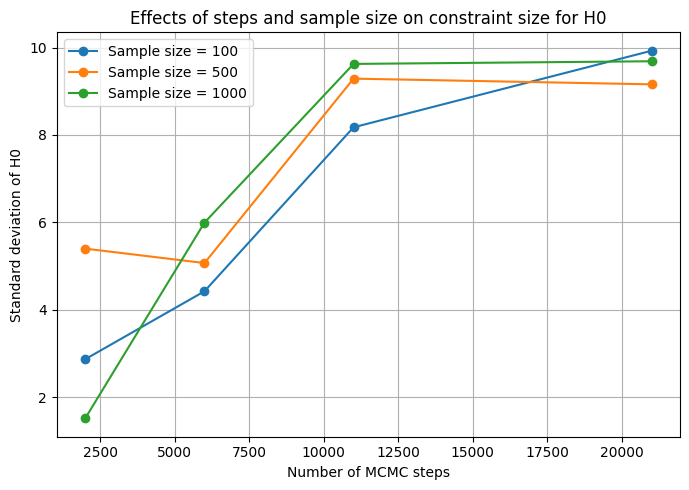

In [11]:
# Choose parameter to plot
param_to_plot = 'H0'
param_index = labels.index(param_to_plot)

fig = plt.figure(figsize=(7, 5))

for j, size in enumerate(sample_size):
    plt.plot(
        steps,
        std_devs[:, j, param_index],  # select correct stds
        marker='o',
        label=f'Sample size = {size}'
    )

plt.xlabel('Number of MCMC steps')
plt.ylabel(f'Standard deviation of {param_to_plot}')
plt.title(f'Effects of steps and sample size on constraint size for {param_to_plot}')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig.savefig("samplesize_steps_effect_on_constraints.png")

### Conclusion of the experiment with w0waCDM and `steps = [2000, 6000, 11000, 21000]; sample_size = [100, 500, 1000]`

Beginning at $n=100$ increasing the number of chain steps only increases the constraint size. Except for $n=500$, which get a small reduction between $2000$ and $6000$ steps (`burn=1000`).

Between $11000$ and $21000$ there is no change, the chain has reached its final.

While lower `nsteps` provide smaller constraints than greater values, the means for greater `nsteps` are more accurate in relation to the accepted parameters (standard cosmology, by a factor of $30\%$).

Explanation: "the more variety we get on the evidence, the more uncertain is the posterior", but at the same time the more data points the more representative.

Next steps: We have to search for the sweetspot:
1. minimising `nsteps` to minimise $\sigma$
2. maximise relative error with standard cosmology

The latter point is tricky because of bias and blind analysis, therefore I proposed creating sample data with known (we don't need $10^4$ events from ET BNS simulations, but just $\sim 500-1000$ events with only $z$ and $d_L$ entries). Creating the code where we try to bring `param_computer/param_true`$\to 1$ will take us to our goals, without being biased by the values we get for the parameters.